# Differential Expression Analysis between two groups of samples

Counts taken from Salmon output for two groups of samples, specified groupings from the dashboard's JSON file.

## Load libraries

In [1]:
# # Install necessary packages
# if (!requireNamespace("BiocManager", quietly = TRUE)) {
#     install.packages("BiocManager")
# }
# BiocManager::install(c("DESeq2", "locfit", "gplots", "pheatmap", "SRAdb", "biomaRt", "EnhancedVolcano"))

# install.packages(c("tidyverse", "readxl", "tibble"))


In [2]:
BiocManager::version()

[1] ‘3.20’

In [3]:
# Load libraries
library(tidyverse)
library(DESeq2)
library(readxl)
library(tibble)
library(locfit)
library(gplots)
library(SRAdb)
library(jsonlite)
library(biomaRt)
library(EnhancedVolcano)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:lubridate’:

    intersect, setdiff, union


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’

## Read in data

**dashboard_metadata**: JSON file with grouping information for samples, as well as their SRA IDs (SRR___) and layout (Single/Paired end). Layout is ignoroed for the analysis.

**gene_counts**: From Salmon output genesCounts.csv (unnormalized integer genomic counts).

In [4]:
# Read in dashboard metadata groupings json (nested list, extract $groups first)
metadata_json <- Sys.getenv("metadata_json")
dashboard_metadata <- fromJSON(metadata_json)$groups

# First column: name, second column: samples (nested list containing "srr_id" and "layout")
# Separate srr_id and layout into separate columns
dashboard_metadata <- dashboard_metadata %>%
    mutate(samples = map(samples, ~ tibble(srr_id = .x$srr_id, layout = .x$layout))) %>%
    unnest(samples) %>%
    # Remove "layout" column, not needed for analysis
    dplyr::select(-layout)

dashboard_metadata

name,srr_id
<chr>,<chr>
Control,SRR10544951
Control,SRR10544956
Control,SRR10544953
Experiment,SRR10544952
Experiment,SRR10544957
Experiment,SRR10544954


In [5]:
# Read in genesCounts.csv (set first column (gene names 'Name') as row names)
counts_dir <- Sys.getenv("counts_dir")
counts_file <- paste0(counts_dir, "/genesCounts.csv")
genes_counts <- read_delim(counts_file,delim = "\t", col_names = TRUE) %>%
    column_to_rownames(var = "Name")

head(genes_counts)

# Column names of genes_counts should match srr_id in dashboard_metadata,
# gene_counts names may have something appended to them, so we need to match
# the srr_id to the column names of genes_counts
# (excluding first column's gene `Name`), and remove any appended text
# (e.g. ".1", ".2", "_trimmed", etc.)
genes_counts <- genes_counts %>%
    # rename_with(~ str_remove(., "\\..*|_trimmed$"), -`Name`) %>%
    # rename_with(~ str_remove(., "_R1$|_R2$"), -`Name`)
    rename_with(~ str_remove(., "\\..*|_trimmed$")) %>%
    rename_with(~ str_remove(., "_1_val$"))

head(genes_counts)

Rows: 38592 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): Name
dbl (6): SRR10544956_1_val, SRR10544952_1_val, SRR10544951_1_val, SRR1054495...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


,SRR10544956_1_val,SRR10544952_1_val,SRR10544951_1_val,SRR10544953_1_val,SRR10544954_1_val,SRR10544957_1_val
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000268674,0,0,0,0,0,0
ENSG00000271254,1391,672,1534,1081,1291,1024
ENSG00000275063,0,0,0,0,0,0
ENSG00000277856,0,0,0,0,0,0
ENSG00000276345,747,0,379,468,0,448
ENSG00000278633,0,0,0,0,0,0


,SRR10544956,SRR10544952,SRR10544951,SRR10544953,SRR10544954,SRR10544957
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000268674,0,0,0,0,0,0
ENSG00000271254,1391,672,1534,1081,1291,1024
ENSG00000275063,0,0,0,0,0,0
ENSG00000277856,0,0,0,0,0,0
ENSG00000276345,747,0,379,468,0,448
ENSG00000278633,0,0,0,0,0,0


In [6]:
# Omit any samples in dashboard_metadata that are not in genes_counts
dashboard_metadata <- dashboard_metadata %>%
    filter(srr_id %in% colnames(genes_counts))

print("SRR IDs not included in genes_counts:")
print(setdiff(dashboard_metadata$srr_id, colnames(genes_counts)))

[1] "SRR IDs not included in genes_counts:"
character(0)


## DESeq2 preparation and execution

In [7]:
### Format dashboard_metadata for DESeq2
# Create a DESeq2 compatible metadata dataframe
# (srr_id as row names, condition as factor)
metadata_df <- dashboard_metadata %>%
    dplyr::select(srr_id, name) %>%
    mutate(condition = as.factor(name)) %>%
    column_to_rownames(var = "srr_id") %>%
    dplyr::select(-name)

metadata_df

,condition
,<fct>
SRR10544951,Control
SRR10544956,Control
SRR10544953,Control
SRR10544952,Experiment
SRR10544957,Experiment
SRR10544954,Experiment


In [8]:
# Final checks: ensure all srr_ids in metadata_df are in genes_counts
if (!all(rownames(metadata_df) %in% colnames(genes_counts))) {
    stop("Some srr_ids in metadata_df are not in genes_counts.")
}

# Ensure the ordering of srr_ids in metadata_df matches column names in genes_counts
if (all(rownames(metadata_df) == colnames(genes_counts))) {
    print("All srr_ids in metadata_df match column names in genes_counts.")
} else {
    print("Mismatch ordering between srr_ids in metadata_df and column names in genes_counts.")
    print("Matching srr_ids to genes_counts column names...")
    genes_counts <- genes_counts[, rownames(metadata_df)]
}

[1] "Mismatch ordering between srr_ids in metadata_df and column names in genes_counts."
[1] "Matching srr_ids to genes_counts column names..."


In [9]:
# Perform DESeq2 analysis
dds <- DESeqDataSetFromMatrix(countData = genes_counts,
                              colData = metadata_df,
                              design = ~ condition)
dds

converting counts to integer mode



class: DESeqDataSet 
dim: 38592 6 
metadata(1): version
assays(1): counts
rownames(38592): ENSG00000268674 ENSG00000271254 ... ENSG00000110721
  ENSG00000144115
rowData names(0):
colnames(6): SRR10544951 SRR10544956 ... SRR10544957 SRR10544954
colData names(1): condition

In [10]:
# Run DESeq2 analysis
# This will perform normalization and statistical testing
dds <- DESeq(dds)
dds

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing



class: DESeqDataSet 
dim: 38592 6 
metadata(1): version
assays(4): counts mu H cooks
rownames(38592): ENSG00000268674 ENSG00000271254 ... ENSG00000110721
  ENSG00000144115
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(6): SRR10544951 SRR10544956 ... SRR10544957 SRR10544954
colData names(2): condition sizeFactor

In [11]:
# Set the alpha level for significance
alpha <- 0.05

# Extract results
res <- results(dds, alpha = alpha)
res
summary(res)

log2 fold change (MLE): condition Experiment vs Control 
Wald test p-value: condition Experiment vs Control 
DataFrame with 38592 rows and 6 columns
                 baseMean log2FoldChange     lfcSE       stat    pvalue
                <numeric>      <numeric> <numeric>  <numeric> <numeric>
ENSG00000268674     0.000             NA        NA         NA        NA
ENSG00000271254  1150.961      -0.356467  0.286017  -1.246312  0.212650
ENSG00000275063     0.000             NA        NA         NA        NA
ENSG00000277856     0.000             NA        NA         NA        NA
ENSG00000276345   327.275      -1.833333  2.914154  -0.629113  0.529275
...                   ...            ...       ...        ...       ...
ENSG00000115593     0.000             NA        NA         NA        NA
ENSG00000225921  2380.283     -0.0184678  0.200216 -0.0922395  0.926508
ENSG00000163586     0.000             NA        NA         NA        NA
ENSG00000110721   284.225      0.2485558  0.288361  0.86196


out of 25184 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 22, 0.087%
LFC < 0 (down)     : 14, 0.056%
outliers [1]       : 80, 0.32%
low counts [2]     : 5694, 23%
(mean count < 2)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



In [12]:
# Number of DEGs
num_degs <- sum(res$padj < alpha, na.rm = TRUE)
cat("Number of differentially expressed genes (DEGs) padj < 0.05: ", num_degs, "\n")
print(paste("Total number of genes:", nrow(res)))
print(paste("Total number of genes with non-NA padj:", sum(!is.na(res$padj))))

Number of differentially expressed genes (DEGs) padj < 0.05:  36 
[1] "Total number of genes: 38592"
[1] "Total number of genes with non-NA padj: 19410"


In [13]:
# Make a dataframe of results
res_df <- as.data.frame(res)

head(res_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG00000268674,0.000,NA,NA,NA,NA,NA
ENSG00000271254,1150.961,-0.3564671,0.2860175,-1.2463123,0.2126497,0.999991
ENSG00000275063,0.000,NA,NA,NA,NA,NA
ENSG00000277856,0.000,NA,NA,NA,NA,NA
ENSG00000276345,327.275,-1.8333329,2.9141542,-0.6291132,0.5292749,0.999991
ENSG00000278633,0.000,NA,NA,NA,NA,NA


In [14]:
# Replace Ensembl IDs gene names with gene symbols with biomaRt
mart <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")
gene_symbols <- getBM(attributes = c("ensembl_gene_id", "external_gene_name"),
                      filters = "ensembl_gene_id",
                      values = rownames(res_df),
                      mart = mart)
head(gene_symbols)
nrow(gene_symbols)

,ensembl_gene_id,external_gene_name
,<chr>,<chr>
1,ENSG00000001036,FUCA2
2,ENSG00000001084,GCLC
3,ENSG00000001167,NFYA
4,ENSG00000001561,ENPP4
5,ENSG00000001629,ANKIB1
6,ENSG00000001631,KRIT1


[1] 37471

In [15]:
# Merge gene symbols with results
res_df <- res_df %>%
    rownames_to_column(var = "ensembl_gene_id") %>%
    left_join(gene_symbols, by = "ensembl_gene_id") %>%
    # Some gene symbols may be empty, so use ensembl_gene_id as fallback
    mutate(gene_symbol = ifelse(is.na(external_gene_name) | external_gene_name == "", ensembl_gene_id, external_gene_name)) %>%
    # Set rownames to ensembl_gene_id again
    column_to_rownames(var = "ensembl_gene_id")

# For some reason column'external_gene_name' cannot be accessed directly,
# need to remove it at column 7
res_df <- res_df[, -7]

In [16]:
head(res_df)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000268674,0.000,NA,NA,NA,NA,NA,ENSG00000268674
ENSG00000271254,1150.961,-0.3564671,0.2860175,-1.2463123,0.2126497,0.999991,ENSG00000271254
ENSG00000275063,0.000,NA,NA,NA,NA,NA,ENSG00000275063
ENSG00000277856,0.000,NA,NA,NA,NA,NA,ENSG00000277856
ENSG00000276345,327.275,-1.8333329,2.9141542,-0.6291132,0.5292749,0.999991,ENSG00000276345
ENSG00000278633,0.000,NA,NA,NA,NA,NA,ENSG00000278633


In [17]:
# Modify res_df to convert row names to a column (Ensomble_IDs), and column gene_symbol be the second column
res_df_csv <- res_df %>%
    rownames_to_column(var = "Ensembl_IDs") %>%
    dplyr::select(Ensembl_IDs, gene_symbol, everything())

head(res_df_csv)

# Write results to CSV
write_csv(res_df_csv, paste0(counts_dir, "/DESeq2_results.csv"))

,Ensembl_IDs,gene_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,ENSG00000268674,ENSG00000268674,0.000,NA,NA,NA,NA,NA
2,ENSG00000271254,ENSG00000271254,1150.961,-0.3564671,0.2860175,-1.2463123,0.2126497,0.999991
3,ENSG00000275063,ENSG00000275063,0.000,NA,NA,NA,NA,NA
4,ENSG00000277856,ENSG00000277856,0.000,NA,NA,NA,NA,NA
5,ENSG00000276345,ENSG00000276345,327.275,-1.8333329,2.9141542,-0.6291132,0.5292749,0.999991
6,ENSG00000278633,ENSG00000278633,0.000,NA,NA,NA,NA,NA


## Analysis & Visualization

agg_record_297481778 
                   2

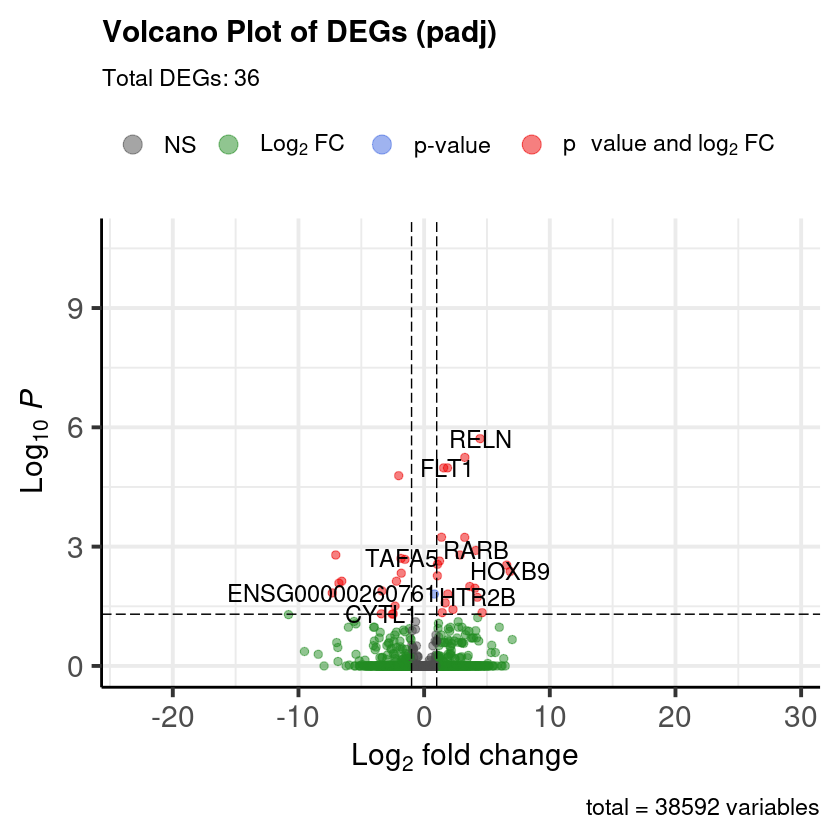

In [18]:
### Create a volcano plot using EnhancedVolcano

# Save plot as PNG file
png(paste0(counts_dir, "/volcano_plot.png"), width = 800, height = 600)

# Change the f-cutoff value here (default is 2)
f_cutoff <- 2

volcano <- EnhancedVolcano(res_df,
                            lab = res_df$gene_symbol,
                            x = 'log2FoldChange',
                            y = 'padj',
                            pCutoff = alpha,
                            # FCcutoff = 1,
                            title = "Volcano Plot of DEGs (padj)",
                            subtitle = paste("Total DEGs:", num_degs))
                            # pointSize = 3.0,
                            # labSize = 3.0,
                            # drawConnectors = TRUE,
                            # widthConnectors = 0.5,
                            # colAlpha = 0.5,
                            # legendPosition = "right",
                            # legendLabSize = 10,
                            # legendIconSize = 3.0)
volcano
dev.off()

# Display plot on notebook
volcano

In [19]:
# Select top 20 DEGs based on padj
top_degs <- res_df %>%
    filter(!is.na(padj) & padj < alpha) %>%
    arrange(padj) %>%
    head(20)  # Change this number to select more/less DEGs
head(top_degs)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,gene_symbol
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG00000189056,1146.9298,4.452844,0.6883995,6.468402,9.904499e-11,1.922463e-06,RELN
ENSG00000133169,153.0906,3.235236,0.5223656,6.193432,5.886800e-10,5.713139e-06,BEX1
ENSG00000102755,292.1867,1.858974,0.3086268,6.023373,1.708195e-09,1.045633e-05,FLT1
ENSG00000133110,107318.3049,1.552898,0.2594353,5.985683,2.154833e-09,1.045633e-05,POSTN
ENSG00000154856,570.8962,-2.024830,0.3446452,-5.875115,4.225504e-09,1.640341e-05,APCDD1
ENSG00000165617,2075.2490,1.380628,0.2645184,5.219404,1.795001e-07,5.806830e-04,DACT1


agg_record_493606339 
                   2

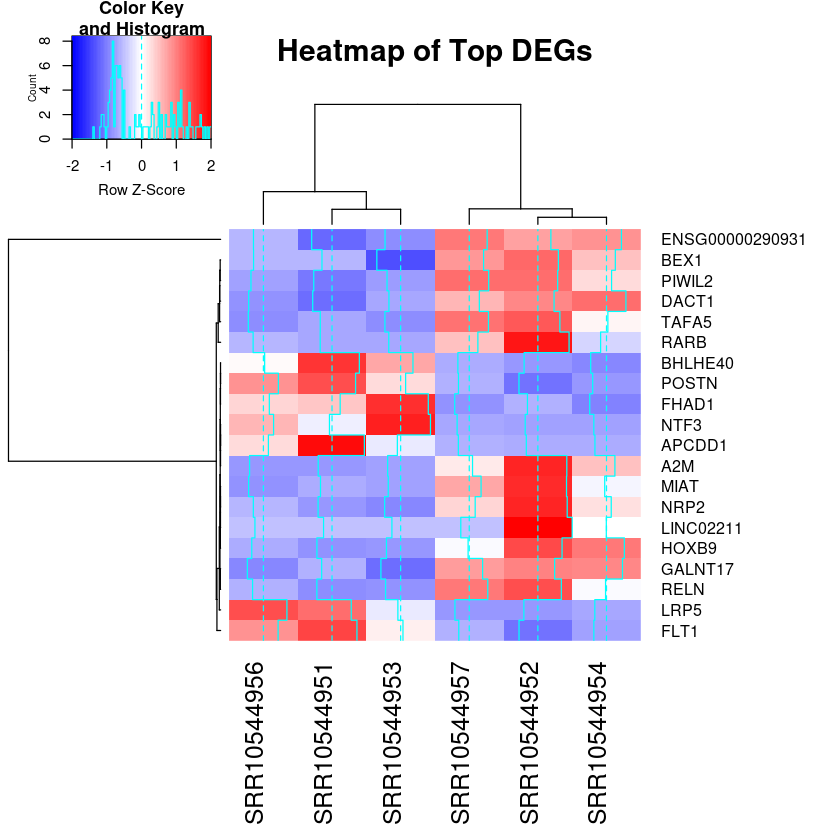

In [20]:
### Create a heatmap of the top DEGs

# Save plot as PNG file
png(paste0(counts_dir, "/heatmap.png"), width = 600, height = 800)

heatmap.2(as.matrix(genes_counts[rownames(genes_counts) %in% rownames(top_degs), ]),
            scale = "row",
            main = "Heatmap of Top DEGs",
            labRow = top_degs$gene_symbol,
            labCol = rownames(metadata_df),
            margins = c(10, 10),
            col = bluered(100))

dev.off()

# Display heatmap on notebook
heatmap.2(as.matrix(genes_counts[rownames(genes_counts) %in% rownames(top_degs), ]),
            scale = "row",
            main = "Heatmap of Top DEGs",
            labRow = top_degs$gene_symbol,
            labCol = rownames(metadata_df),
            margins = c(10, 10),
            col = bluered(100))